In [1]:
!pip install -q transformers datasets scikit-learn pandas

In [2]:
from google.colab import files
import os

In [16]:
import pandas as pd
import torch
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
file_path = r"/content/Sentences_66Agree.txt"

# Use cp1252 encoding instead of utf-8
with open(file_path, 'r', encoding='cp1252') as f:
    lines = f.readlines()

# Inspect
print(lines[:5])

sentences = []
labels = []

for line in lines:
    line = line.strip()
    if not line:
        continue
    if "@positive" in line:
        label = "positive"
        text = line.replace("@positive", "").strip()
    elif "@negative" in line:
        label = "negative"
        text = line.replace("@negative", "").strip()
    elif "@neutral" in line:
        label = "neutral"
        text = line.replace("@neutral", "").strip()
    else:
        continue  # skip malformed lines

    sentences.append(text)
    labels.append(label)

print(f"Loaded {len(sentences)} sentences.")

# 3️⃣ Map labels to integers
df = pd.DataFrame({"text": sentences, "label": labels})
df['label'] = df['label'].map({"negative": 0, "neutral": 1, "positive": 2})

# Inspect
print(df.head())
print(df['label'].value_counts())


# Split into train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])


# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenization
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

def preprocess(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .@neutral\n', 'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .@neutral\n', 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .@positive\n', "According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales .@positive\n", "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .@positive\n"]
Loaded 

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/3373 [00:00<?, ? examples/s]

Map:   0%|          | 0/844 [00:00<?, ? examples/s]

In [5]:
# Load FinBERT pre-trained for sentiment classification
model = AutoModelForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-tone",
    num_labels=3,  # positive, neutral, negative
    ignore_mismatched_sizes=True
)

print(f"✓ Model loaded with {model.num_parameters():,} parameters")

✓ Model loaded with 109,754,115 parameters


In [6]:
# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    f1_per_class = f1_score(labels, predictions, average=None)

    return {
        "accuracy": acc,
        "f1": f1,
        "f1_negative": f1_per_class[0],
        "f1_neutral": f1_per_class[1],
        "f1_positive": f1_per_class[2],
    }

In [9]:
training_args = TrainingArguments(
    output_dir="./finbert_full_ft",
    num_train_epochs=2,                 # Reduce epochs from 3 → 2
    per_device_train_batch_size=32,     # Increase batch size from 16 → 32
    per_device_eval_batch_size=32,      # Match eval batch size
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",        # Evaluate every few steps instead of full epoch
    eval_steps=100,                     # Evaluate every 100 steps
    save_strategy="steps",              # Save checkpoints every few steps
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,                          # Use mixed precision if GPU supports it
    gradient_accumulation_steps=1,      # Can increase if GPU memory is limited
    report_to="none",
)


In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Accuracy,F1,F1 Negative,F1 Neutral,F1 Positive
100,0.534600,0.512832,0.792654,0.800758,0.633588,0.867925,0.728814
200,0.281300,0.366130,0.860190,0.860399,0.730769,0.907115,0.816239


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=212, training_loss=0.7128630190525415, metrics={'train_runtime': 10196.4272, 'train_samples_per_second': 0.662, 'train_steps_per_second': 0.021, 'total_flos': 443740778998272.0, 'train_loss': 0.7128630190525415, 'epoch': 2.0})

In [11]:
print("\n🚀 Starting full fine-tuning...")
eval_results_full = trainer.evaluate()

print("-" * 40)
for key, value in eval_results_full.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '').upper()
        print(f"{metric_name}: {value:.4f}")

predictions_full = trainer.predict(test_dataset)
y_pred_full = np.argmax(predictions_full.predictions, axis=-1)
y_true = predictions_full.label_ids

# Save model
print("\n💾 Saving full fine-tuned model...")
trainer.save_model("./news_classifier_full_finetuning")
tokenizer.save_pretrained("./news_classifier_full_finetuning")


🚀 Starting full fine-tuning...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


----------------------------------------
LOSS: 0.3661
ACCURACY: 0.8602
F1: 0.8604
F1_NEGATIVE: 0.7308
F1_NEUTRAL: 0.9071
F1_POSITIVE: 0.8162
RUNTIME: 356.1300
SAMPLES_PER_SECOND: 2.3700
STEPS_PER_SECOND: 0.0760


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



💾 Saving full fine-tuned model...


('./news_classifier_full_finetuning/tokenizer_config.json',
 './news_classifier_full_finetuning/special_tokens_map.json',
 './news_classifier_full_finetuning/vocab.txt',
 './news_classifier_full_finetuning/added_tokens.json',
 './news_classifier_full_finetuning/tokenizer.json')


📊 Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.74      0.73       103
     neutral       0.91      0.91      0.91       507
    positive       0.82      0.82      0.82       234

    accuracy                           0.86       844
   macro avg       0.82      0.82      0.82       844
weighted avg       0.86      0.86      0.86       844



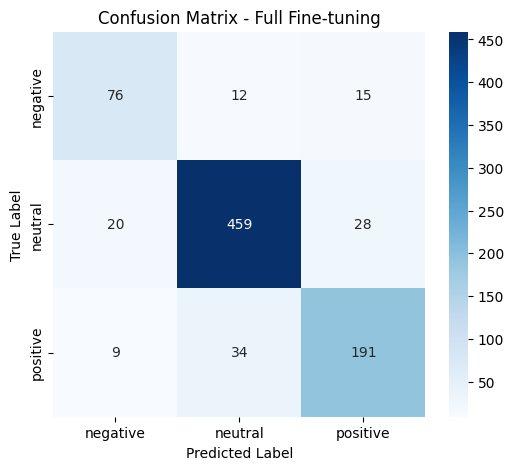

In [17]:
# Classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_full, target_names=["negative", "neutral", "positive"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_full)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"])

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Full Fine-tuning")
plt.show()


In [18]:
metrics_df.head()
metrics_df.columns

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_accuracy', 'eval_f1', 'eval_f1_negative', 'eval_f1_neutral',
       'eval_f1_positive', 'eval_runtime', 'eval_samples_per_second',
       'eval_steps_per_second', 'train_runtime', 'train_samples_per_second',
       'train_steps_per_second', 'total_flos', 'train_loss'],
      dtype='object')

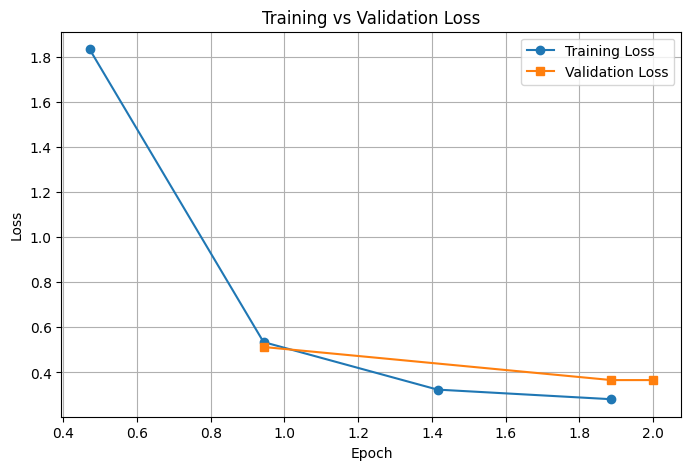

In [19]:
# Separate training and evaluation logs
train_loss_df = metrics_df[metrics_df["loss"].notnull()]
eval_loss_df = metrics_df[metrics_df["eval_loss"].notnull()]

plt.figure(figsize=(8, 5))
plt.plot(train_loss_df["epoch"], train_loss_df["loss"], 'o-', label="Training Loss")
plt.plot(eval_loss_df["epoch"], eval_loss_df["eval_loss"], 's-', label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
